<a href="https://colab.research.google.com/github/myprogrammerpersonality/BlackBoxOptimizer/blob/master/BBO_Funcv3_1_NotebookvDev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Black Box Optimizer v3.1: </h1>
+ Log Scale Random Number Through Manual Input<br>           
+ Multiple Stocks<br>
+ Multiple Alternatives<br>
+ Echo Machine File Output<br>
+ Table2Speech File Output<br>
+ Visualising Results as BoxPlot<br>
+ Visualising Results for each Metabolite<br>
+ Visualising Concentrations for each Day<br>
+ Find K Most Informative combinations<br>
+ Find Metabolite's Importance<br>
+ Find NonLinear Interactions<br>



In [1]:
import pandas as pd
import numpy as np
import os
from xgboost import XGBRegressor
import time
from sklearn.model_selection import RandomizedSearchCV
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from collections.abc import Iterable
import math
import random
from scipy.stats import spearmanr, pearsonr

pd.options.mode.chained_assignment = None  # default='warn'
!wget https://raw.githubusercontent.com/myprogrammerpersonality/BlackBoxOptimizer/master/Functions_Final_v3_1.py

from Functions_Final_v3_1 import *

--2020-10-17 08:59:43--  https://raw.githubusercontent.com/myprogrammerpersonality/BlackBoxOptimizer/master/Functions_Final_v3_1.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18371 (18K) [text/plain]
Saving to: ‘Functions_Final_v3_1.py’

Functions_Final_v3_ 100%[===================>]  17.94K  --.-KB/s    in 0.01s   

2020-10-17 08:59:43 (1.45 MB/s) - ‘Functions_Final_v3_1.py’ saved [18371/18371]



This notebook includes all data processing, bayesian optimization and results visualisation

# User Inputs

<p1><h2> When to use this part:</h2>
* every time before using BBO you should fill this part based on your project</p1>
<p1><h2> How to use this part:</h2>
* User should upload all available Results file (i.e. Results_1.csv to Results_n.csv) to runtime from Files/UploadFile
* now there is an example, change it to your project</p1>

In [2]:
# General Parameters:
m = 20      # number_of_combination_each_round
minimum_drop_size_nanoliter = 100
final_reaction_volume_nanoliter = 20000
maximum_volume_of_model_output = 9300 # (e.g. volume except fixed parts - 100 nl avoid 0 water)
fixed_parts = {'Lysate':0.33, 'EnergyBuffer':0.175, 'IPTG-Water':0.025} # 0.33 means 33% of total volume will be Lysate, 15% energy mix(except variable one), 2.5% IPTG
days_total = 10 # how many days you want to continue # set it at your max prediction

# Model Parameters:
RandomCV = True
n_iter = 200
ensemble_len = 20 
exploration = {1: 1.41, 2: 1.41, 3: 1.41,
               4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0,
               8: 0.5, 9: 0.5, 9: 0.5, 10: 0.5}
days_range = [m for i in range(days_total)]

In [3]:
# Part 1: choose grid for our metabolite conc and define stock concentration

# it is important to define all value for function to be able to get conc that is appropriate to your minimum drop size
# each metabolite min, max and stock must be in same units

# concentrations_limits :
# *** metabolite name must not includes "_" ***

concentrations_limits = {
 'PEG':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], 'Conc_Stock':50.0, 'Alternatives':None},
 'DTT':{'Conc_Min':0.0, 'Conc_Max':4.0, 'Conc_Values':None, 'Conc_Stock':100.0, 'Alternatives':None},
 'Spermidine':{'Conc_Min':0.2, 'Conc_Max':2.0, 'Conc_Values':None, 'Conc_Stock':40.0, 'Alternatives':None},
 'T7Pol':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[0.0078, 0.0156, 0.0273, 0.039, 0.0507, 0.0624, 0.0702, 0.078], 'Conc_Stock':0.78, 'Alternatives':None},
 't-RNA':{'Conc_Min':0.04, 'Conc_Max':0.04, 'Conc_Values':None, 'Conc_Stock':8.0, 'Alternatives':None},
 'AminoAcids':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[0.75], 'Conc_Stock':6.0, 'Alternatives':None},
 'TF-plasmid':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[5.0,10.0,20.0,40.0,60.0,80.0,100.0], 'Conc_Stock':2000.0, 'Alternatives':None},
 'Circuit-plasmid':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[10.0], 'Conc_Stock':1000.0, 'Alternatives':['pTAC','pTHS','pDC','pSTAR']}}

In [4]:
# Check Possible Concentrations
data_lists = {}
num = 0 
for key, value in concentrations_limits.items():
    print('Possible Conc For :',key)
    if not value['Conc_Values']:
        print('Your Min, Max :', "({}, {})".format(value['Conc_Min'], value['Conc_Max']))
    concs, vols = allowed_output(value, reaction_vol_nl = final_reaction_volume_nanoliter, drop_size_nl = minimum_drop_size_nanoliter, verbose=0)
    print(concs)
    print(vols)
    data_lists[num] = vols
    num += 1
    print()

percent , pool_size = percentage_possible(data_lists, threshold = maximum_volume_of_model_output)
print(percent, f'% of {pool_size} possible combination are executable!')
if pool_size > 10000000: pool_size = 10000000

Possible Conc For : PEG
[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
[400.0, 600.0, 800.0, 1000.0, 1200.0, 1400.0, 1600.0, 1800.0, 2000.0]

Possible Conc For : DTT
Your Min, Max : (0.0, 4.0)
[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
[0, 100, 200, 300, 400, 500, 600, 700, 800]

Possible Conc For : Spermidine
Your Min, Max : (0.2, 2.0)
[0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

Possible Conc For : T7Pol
[0.0078, 0.0156, 0.0273, 0.039, 0.0507, 0.0624, 0.0702, 0.078]
[200.0, 400.0, 700.0, 1000.0, 1300.0, 1600.0, 1800.0, 2000.0]

Possible Conc For : t-RNA
Your Min, Max : (0.04, 0.04)
[0.04]
[100]

Possible Conc For : AminoAcids
[0.75]
[2500.0]

Possible Conc For : TF-plasmid
[5.0, 10.0, 20.0, 40.0, 60.0, 80.0, 100.0]
[50.0, 100.0, 200.0, 400.0, 600.0, 800.0, 1000.0]

Possible Conc For : Circuit-plasmid
[10.0]
[200.0]

99.98015873015873 % of 45360 possible combination are executable!


In [5]:
# add reference and negative control
# leave it empty if you dont need
# you can add more desired combination to this dictionary
# *** conc in these dic must be compatible with minimum drop size ***

specials = {}

# Day 1 (in absence of Day_0)

<p1><h2> When to use this part:</h2>
* after filling "User Input" if you have no pre existing data (Day_0.csv) 
<p1><h2> How to use this part:</h2>
* just run all cells!


In [ ]:
# make random combinations
Concentrations_1 = random_combination_generator(concentrations_limits, number_of_combination = m,
                                                reaction_vol_nl=final_reaction_volume_nanoliter,
                                                max_nl=maximum_volume_of_model_output, drop_size_nl=minimum_drop_size_nanoliter, return_df=True)

# add control, reference and other desired combinations
df_specials = [pd.DataFrame(i) for i in specials.values()]
Concentrations_1 = pd.concat([Concentrations_1, *df_specials]).reset_index(drop=True)

Concentrations_1

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_pTAC,Circuit-plasmid_pTHS,Circuit-plasmid_pDC,Circuit-plasmid_pSTAR
0,2.0,4.0,1.8,0.0507,0.04,0.75,60.0,10.0,0.0,0.0,1.0,0.0
1,4.5,3.0,1.8,0.0273,0.04,0.75,5.0,10.0,1.0,0.0,0.0,0.0
2,2.0,2.0,2.0,0.0390,0.04,0.75,10.0,10.0,0.0,1.0,0.0,0.0
3,3.5,3.5,0.4,0.0390,0.04,0.75,100.0,10.0,1.0,0.0,0.0,0.0
4,1.5,1.5,1.6,0.0156,0.04,0.75,80.0,10.0,1.0,0.0,0.0,0.0
5,2.0,3.5,1.4,0.0702,0.04,0.75,40.0,10.0,0.0,0.0,1.0,0.0
6,3.5,0.0,0.6,0.0507,0.04,0.75,80.0,10.0,1.0,0.0,0.0,0.0
7,2.5,3.5,1.4,0.0780,0.04,0.75,100.0,10.0,0.0,1.0,0.0,0.0
8,1.5,0.5,1.6,0.0624,0.04,0.75,10.0,10.0,0.0,1.0,0.0,0.0
9,3.5,0.5,2.0,0.0702,0.04,0.75,100.0,10.0,0.0,0.0,1.0,0.0


In [ ]:
!mkdir -p Day_1
Concentrations_1.to_csv('Day_1/Concentrations_1.csv', index=False)

In [ ]:
# concentration_to_volume
Volumes_1 = concentration_to_volume(Concentrations_1, concentrations_limits, reaction_mixture_vol_nl=final_reaction_volume_nanoliter,
                                    fixed_parts=fixed_parts)
Volumes_1.to_csv('Day_1/Volumes_1.csv', index=False)
Volumes_1

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_Type,Lysate,EnergyBuffer,IPTG-Water,water
0,800.0,800.0,900.0,1300.0,100.0,2500.0,600.0,200.0,pDC,6600.0,3500.0,500.0,2200.0
1,1800.0,600.0,900.0,700.0,100.0,2500.0,50.0,200.0,pTAC,6600.0,3500.0,500.0,2550.0
2,800.0,400.0,1000.0,1000.0,100.0,2500.0,100.0,200.0,pTHS,6600.0,3500.0,500.0,3300.0
3,1400.0,700.0,200.0,1000.0,100.0,2500.0,1000.0,200.0,pTAC,6600.0,3500.0,500.0,2300.0
4,600.0,300.0,800.0,400.0,100.0,2500.0,800.0,200.0,pTAC,6600.0,3500.0,500.0,3700.0
5,800.0,700.0,700.0,1800.0,100.0,2500.0,400.0,200.0,pDC,6600.0,3500.0,500.0,2200.0
6,1400.0,0.0,300.0,1300.0,100.0,2500.0,800.0,200.0,pTAC,6600.0,3500.0,500.0,2800.0
7,1000.0,700.0,700.0,2000.0,100.0,2500.0,1000.0,200.0,pTHS,6600.0,3500.0,500.0,1200.0
8,600.0,100.0,800.0,1600.0,100.0,2500.0,100.0,200.0,pTHS,6600.0,3500.0,500.0,3400.0
9,1400.0,100.0,1000.0,1800.0,100.0,2500.0,1000.0,200.0,pDC,6600.0,3500.0,500.0,1300.0


# Other Days

<p1><h2> When to use this part:</h2>
* whene you have either pre existing data (Results_0.csv) or Results_1 to Results_n
<p1><h2> How to use this part:</h2>
* just run all cells!

In [ ]:
day = day_finder('Results') - 1
start_day = (1, 0)[os.path.isfile('Results_0.csv')]
print(start_day, day)

0 5


In [ ]:
desired_cols = []
for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

aggregated_data_m = pd.DataFrame(columns=desired_cols)
aggregated_label_m = pd.DataFrame(columns=['yield'])

for num in range(start_day, day + 1):
    if start_day or num>0:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, days_range[num-1])
    else:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))

    aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)

if 'reference' in specials.keys():
    ref_data = pd.DataFrame(specials['reference'])
    ref_label = pd.DataFrame({'yield':[1.0]})
    aggregated_data_m = pd.concat([aggregated_data_m, ref_data[desired_cols]]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, ref_label]).reset_index(drop=True)

aggregated_data_m

0
s 1
s 2
s 3
s 4
s 5


,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_pTAC,Circuit-plasmid_pTHS,Circuit-plasmid_pDC,Circuit-plasmid_pSTAR
0,1.5,1.0,1.0,0.0273,0.12,1.50,40,10,0,0,1,0
1,1.0,4.0,1.6,0.0507,0.08,0.48,5,10,0,0,1,0
2,3.0,2.0,1.8,0.0507,0.08,0.48,5,10,0,1,0,0
3,2.5,4.0,0.2,0.0273,0.20,1.26,100,10,0,0,0,1
4,1.0,0.0,0.6,0.0273,0.08,1.11,60,10,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
195,2.0,2.5,0.2,0.0156,0.20,0.75,20,10,0,1,0,0
196,3.0,2.5,0.2,0.0702,0.16,0.60,80,10,0,1,0,0
197,3.5,2.0,0.2,0.0078,0.04,0.60,10,10,0,1,0,0
198,3.5,2.0,0.2,0.0078,0.16,0.48,60,10,0,1,0,0


In [ ]:
# our ensemble of regressors
# XGBRegressor is an enhanced random forest boosted algorithm
RandomCV = True
if RandomCV:
    # create a default XGBoost classifier
    model = XGBRegressor(objective = 'reg:squarederror')

    # Create the grid search parameter grid and scoring funcitons
    param_grid = {
        "learning_rate": [0.01, 0.03, 0.1, 0.3],
        "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
        "subsample": [0.6, 0.8, 0.9, 1.0],
        "max_depth": [2, 3, 4, 6 , 8],
        "n_estimators": [10, 20,  40, 60, 80, 100, 300, 500],
        "reg_lambda": [1, 1.5, 2],
        "gamma": [0, 0.1, 0.4, 0.6],
        "min_child_weight": [1, 2, 4]}

    # create the grid search object
    grid = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_grid,
        cv=5,
        scoring= 'neg_mean_absolute_error',
        n_jobs=-1,
        n_iter=n_iter)
    
    print('RandomSearchCV ...')
    grid.fit(aggregated_data_m.values, aggregated_label_m.values)
    results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
    regressors_list = [XGBRegressor(
                       objective = 'reg:squarederror',**param) for param in results.params.iloc[0:ensemble_len,] ]
    print('RandomSearchCV Done!')

else:
    # Default
    regressors_list = [XGBRegressor(
        objective = 'reg:squarederror',
        n_estimators = n,
        learning_rate = l ,
        max_depth = 6,
        min_child_weight = 4,
        subsample = 0.9,
        gamma = 0.4,
        colsample_bytree = 0.9) for n in (10, 20, 30, 40, 50) for l in (0.01, 0.03, 0.1, 0.2)]

RandomSearchCV ...
RandomSearchCV Done!


In [ ]:
pool_size

45360

In [ ]:
t0 = time.time()

pool_size = 10000 # for when you want to change pool size, default = all possible combinations

Concentrations_n_m = bayesian_optimization(regressors_list, aggregated_data_m, aggregated_label_m, concentrations_limits,
                                           final_order=final_order,
                                           df_main = aggregated_data_m,
                                           reaction_vol_nl=final_reaction_volume_nanoliter, max_nl=maximum_volume_of_model_output,
                                           drop_size_nl=minimum_drop_size_nanoliter,
                                           exploitation=1, exploration=exploration[day+1], test_size=m, pool_size=pool_size, verbose=0,
                                           day=day, days_range = days_range)

print("Passed Time(s): ",time.time()-t0)

Concentrations_n_m

Passed Time(s):  0.4772348403930664


,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_pTAC,Circuit-plasmid_pTHS,Circuit-plasmid_pDC,Circuit-plasmid_pSTAR,pred_yield_0,pred_yield_1,pred_yield_2,pred_yield_3,pred_yield_4,pred_yield_5,pred_yield_6,pred_yield_7,pred_yield_8,pred_yield_9,pred_yield_10,pred_yield_11,pred_yield_12,pred_yield_13,pred_yield_14,pred_yield_15,pred_yield_16,pred_yield_17,pred_yield_18,pred_yield_19,regressors_std,mean_vote,UCB
994,3.5,0.5,0.2,0.0078,0.04,0.75,5.0,10.0,0.0,1.0,0.0,0.0,8153.120605,7776.189453,6248.678223,7988.820801,5227.208984,5807.920410,8170.597168,5011.734375,6765.387695,4937.337402,5966.135742,5633.669922,6565.870117,8509.618164,5879.412598,4099.757812,4965.311523,5001.226074,5040.971191,11469.009766,1760.292114,6460.898438,8942.910156
273,3.5,1.0,0.4,0.0078,0.04,0.75,5.0,10.0,0.0,1.0,0.0,0.0,6841.368164,5907.677246,5342.227051,7908.425293,4429.570801,5223.012207,6996.453125,3852.519775,5949.994629,4937.337402,5405.480469,4384.403809,6565.870117,6815.531738,5262.678711,3227.201660,3754.412354,3834.845947,4351.733398,10524.882812,1718.339355,5575.781250,7998.639648
938,3.0,1.5,1.0,0.0078,0.04,0.75,5.0,10.0,0.0,1.0,0.0,0.0,5291.431152,5241.471680,4274.591309,6257.798828,3396.892578,4008.229248,6069.470703,3741.459229,5359.634277,4937.337402,4913.283203,4250.997559,5962.226074,5538.220215,3615.085693,3117.345215,3496.355225,3834.845947,4086.870361,8807.541992,1340.475708,4810.053711,6700.124512
307,3.0,0.5,1.2,0.0078,0.04,0.75,10.0,10.0,0.0,1.0,0.0,0.0,4944.444824,5241.471680,4361.708984,6204.528320,3493.202393,4019.127197,6178.560547,3740.254639,5341.443848,4937.337402,4917.621094,4349.153320,5144.382812,5522.938965,4075.168457,3117.345215,3481.150879,3834.845947,3996.342041,8627.510742,1260.828369,4776.426758,6554.194824
70,2.0,0.0,0.8,0.0078,0.04,0.75,5.0,10.0,0.0,1.0,0.0,0.0,3306.040039,4762.824707,4585.277832,6891.573242,3707.602051,3976.847656,6179.545898,3703.670654,5343.155762,4937.337402,4917.621094,4305.094238,5962.226074,5115.735352,3977.729004,3085.639160,3469.291504,3834.845947,4138.947754,7274.284668,1174.532837,4673.764160,6329.855469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,5.0,4.0,1.2,0.0624,0.04,0.75,60.0,10.0,0.0,1.0,0.0,0.0,4.033204,13.397259,-8.390641,-51.140118,20.903374,5.764134,1.122103,21.709534,-7.567687,5.141364,-3.209303,14.436257,479.452087,16.148117,-9.056367,90.922531,15.567506,-8.718486,-29.442535,5.714260,109.350800,28.839325,183.023956
382,2.5,4.0,1.6,0.0780,0.04,0.75,80.0,10.0,0.0,1.0,0.0,0.0,-33.000801,3.344628,-7.498409,-57.868397,25.965059,9.645633,-19.895164,2.387394,-12.084930,5.141364,-2.766804,115.046806,479.452087,-50.630028,-8.124168,45.823635,2.008427,-8.718486,-17.290312,-15.494105,113.309319,22.772171,182.538300
351,5.0,4.0,1.2,0.0780,0.04,0.75,100.0,10.0,0.0,1.0,0.0,0.0,-9.416920,5.647827,-21.165165,-62.699364,9.605469,0.493697,-4.872190,9.016629,-12.739238,9.876455,-4.107036,29.731291,479.452087,-43.228634,-8.555636,111.616806,8.088563,-8.718486,-25.591040,-10.985830,112.591293,22.572464,181.326187
899,4.5,2.5,2.0,0.0390,0.04,0.75,100.0,10.0,0.0,1.0,0.0,0.0,-30.023449,-42.649742,-44.239574,-54.999359,-11.417670,-2.472259,-10.985770,37.028286,-12.739238,9.876455,-2.766804,-28.213394,485.081146,-90.124405,-5.015872,106.975105,-15.009580,-8.718486,-31.175087,-19.793667,117.952011,11.430834,177.743164


In [ ]:
# add control, reference and other desired combinations
df_specials = [pd.DataFrame(i) for i in specials.values()]
Concentrations_n = pd.concat([Concentrations_n_m, *df_specials]).reset_index(drop=True)

name_folder = 'Day_{}'.format(day+1)
! mkdir -p {name_folder}

Concentrations_n.to_csv('Day_{}/Concentrations_{}.csv'.format(day+1, day+1), index=False)

In [ ]:
# check to dont make repeated combination
df_main = aggregated_data_m

comparison_df = df_main.merge(pd.read_csv('Day_{}/Concentrations_{}.csv'.format(day+1, day+1)).iloc[:m,:],
                              indicator=True,
                              how='outer')

comparison_df._merge.unique()

[left_only, right_only]
Categories (2, object): [left_only, right_only]

In [ ]:
# concentration_to_volume
Volumes_n = concentration_to_volume(Concentrations_n, concentrations_limits, reaction_mixture_vol_nl=final_reaction_volume_nanoliter, fixed_parts=fixed_parts)

Volumes_n.to_csv('Day_{}/Volumes_{}.csv'.format(day+1, day+1), index=False)

# Visualising Results as BoxPlot


<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file 
<p1><h2> How to use this part:</h2>
* just run all cells!
* you can change some graphing parameter

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 55.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 45.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


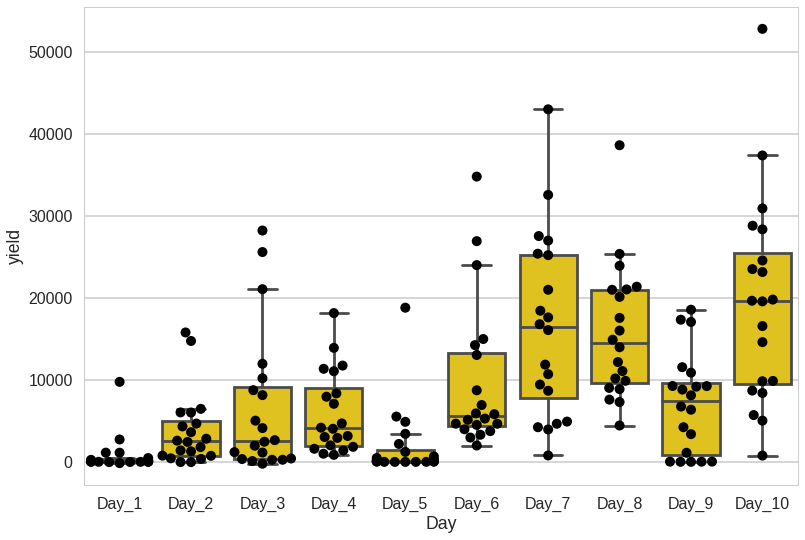

In [ ]:
display_std = False # if you have included "yield_std" column in Results.csv will show it else disply 0 for std
day = day_finder('Results')
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

Results_m = pd.DataFrame(columns=['yield', 'std', 'Day'])
for i in range(start_day, day):
    Results_i = pd.DataFrame(columns=['yield', 'std', 'Day'])
    if start_day:
        Results_i['yield'] = pd.read_csv(f'Results_{i}.csv')['yield'].iloc[0:days_range[i-1]]
    else:
        Results_i['yield'] = pd.read_csv(f'Results_{i}.csv')['yield'].iloc[0:len(pd.read_csv('Results_0.csv'))]

    try:
        if start_day:
            Results_i['std'] = pd.read_csv(f'Results_{i}.csv')['yield_std'].iloc[0:days_range[i-1]]
        else:
            Results_i['std'] = pd.read_csv(f'Results_{i}.csv')['yield_std'].iloc[0:len(pd.read_csv('Results_0.csv'))]

    except:
        Results_i['std'] = 0
    Results_i['Day'] = f'Day_{i}'
    Results_m = pd.concat([Results_m, Results_i])

plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
fig, ax = plt.subplots(1, 1)

ax = sns.boxplot(x='Day', y='yield', data=Results_m, color='gold', fliersize=0)
ax = sns.swarmplot(x='Day', y='yield', data=Results_m, color='k', size=10)

if display_std:
    # Find the x,y coordinates for each point
    x_coords = []
    y_coords = []
    for point_pair in ax.collections:
        for x, y in point_pair.get_offsets():
            x_coords.append(x)
            y_coords.append(y)

    errors = Results_m['std']
    ax.errorbar(x_coords, y_coords, yerr=errors, fmt=' ',color="grey", zorder=3, linewidth=1.2)
    print(errors, x_coords, y_coords)

ax

In [ ]:
fig.savefig(f'Day_{day-1}_Boxplot.png', format='png', dpi=1200)
fig.savefig(f'Day_{day-1}_Boxplot.svg', format='svg', dpi=1200)

# Visualising Results For Each Metabolite

<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file 
<p1><h2> How to use this part:</h2>
* just run all cells!
* you can change some graphing parameter

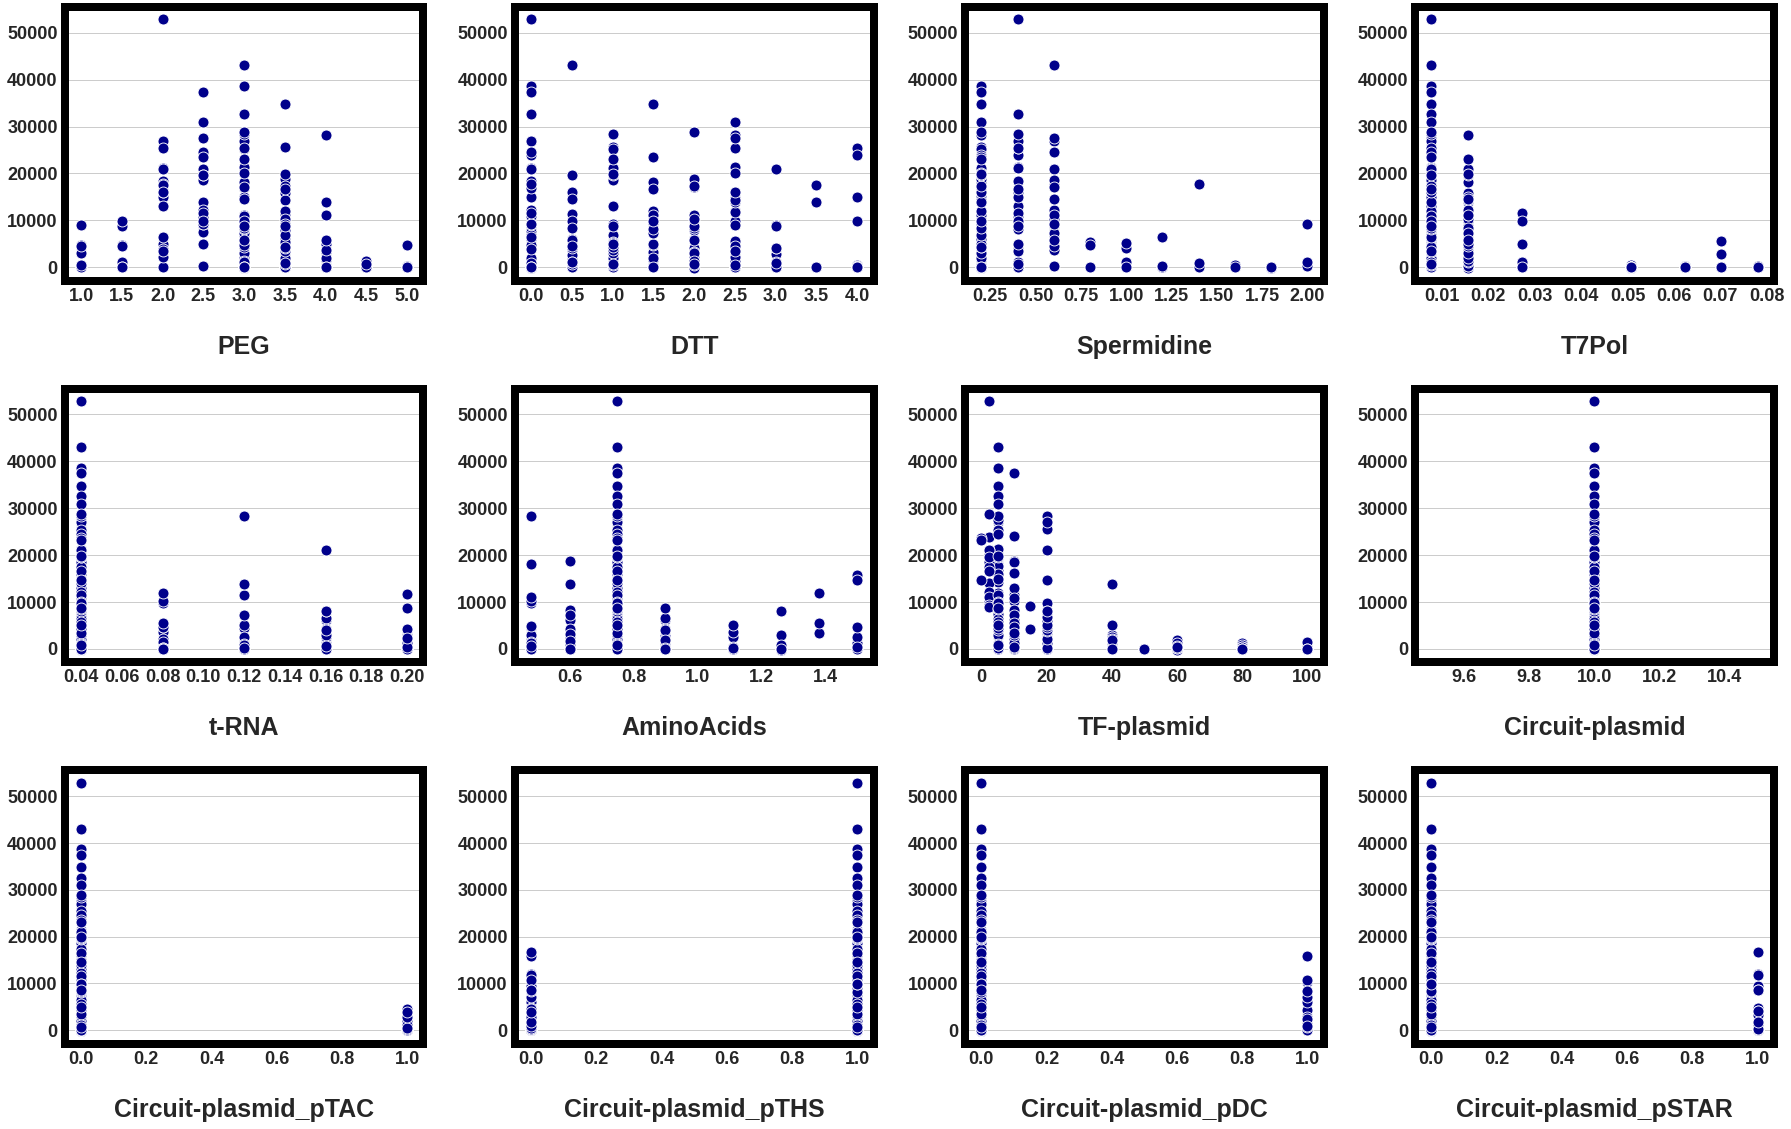

In [ ]:
desired_cols = []
day = day_finder('Results')
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

aggregated_data_m = pd.DataFrame(columns=desired_cols)
aggregated_label_m = pd.DataFrame(columns=['yield'])

for num in range(start_day, day):
    if start_day:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, days_range[num-1])
    else:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))

    aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)

plt.style.use('seaborn-whitegrid')

num = len(desired_cols)
dim = math.ceil(math.sqrt(num))
data = pd.concat([aggregated_data_m, aggregated_label_m], axis=1)

import matplotlib as mpl


mpl.rcParams['axes.linewidth'] = 8.0 #set the value globally
mpl.rcParams['axes.edgecolor'] = 'black' #set the value globally

fig = plt.figure(figsize=(25,20))

for i in range(1, num+1):
    ax = plt.subplot(dim, dim, i)
    ax.xaxis.grid(False)
    ax = sns.scatterplot(x = desired_cols[i-1], y='yield', color='darkblue', data=data, s=120)
    y_axis = ax.axes.get_yaxis()
    y_axis.set_label_text('foo')
    y_label = y_axis.get_label()
    ##print isinstance(x_label, matplotlib.artist.Artist)
    y_label.set_visible(False)
    #ax.xaxis.set_tick_params()
    plt.xticks(weight = 'bold', fontsize=18)
    plt.yticks(weight = 'bold', fontsize=18)

    plt.xlabel(desired_cols[i-1], labelpad=30 ,fontsize=25, weight='bold')


fig.tight_layout(h_pad=3, w_pad=3)

In [ ]:
fig.savefig(f'Day_{day-1}_Metabolite_Yield.png', format='png', dpi=1200)
fig.savefig(f'Day_{day-1}_Metabolite_Yield.svg', format='svg', dpi=1200)

# Viualising Concentrations From Day_1 to Now

<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file 
<p1><h2> How to use this part:</h2>
* just run all cells!
* you can change some graphing parameter

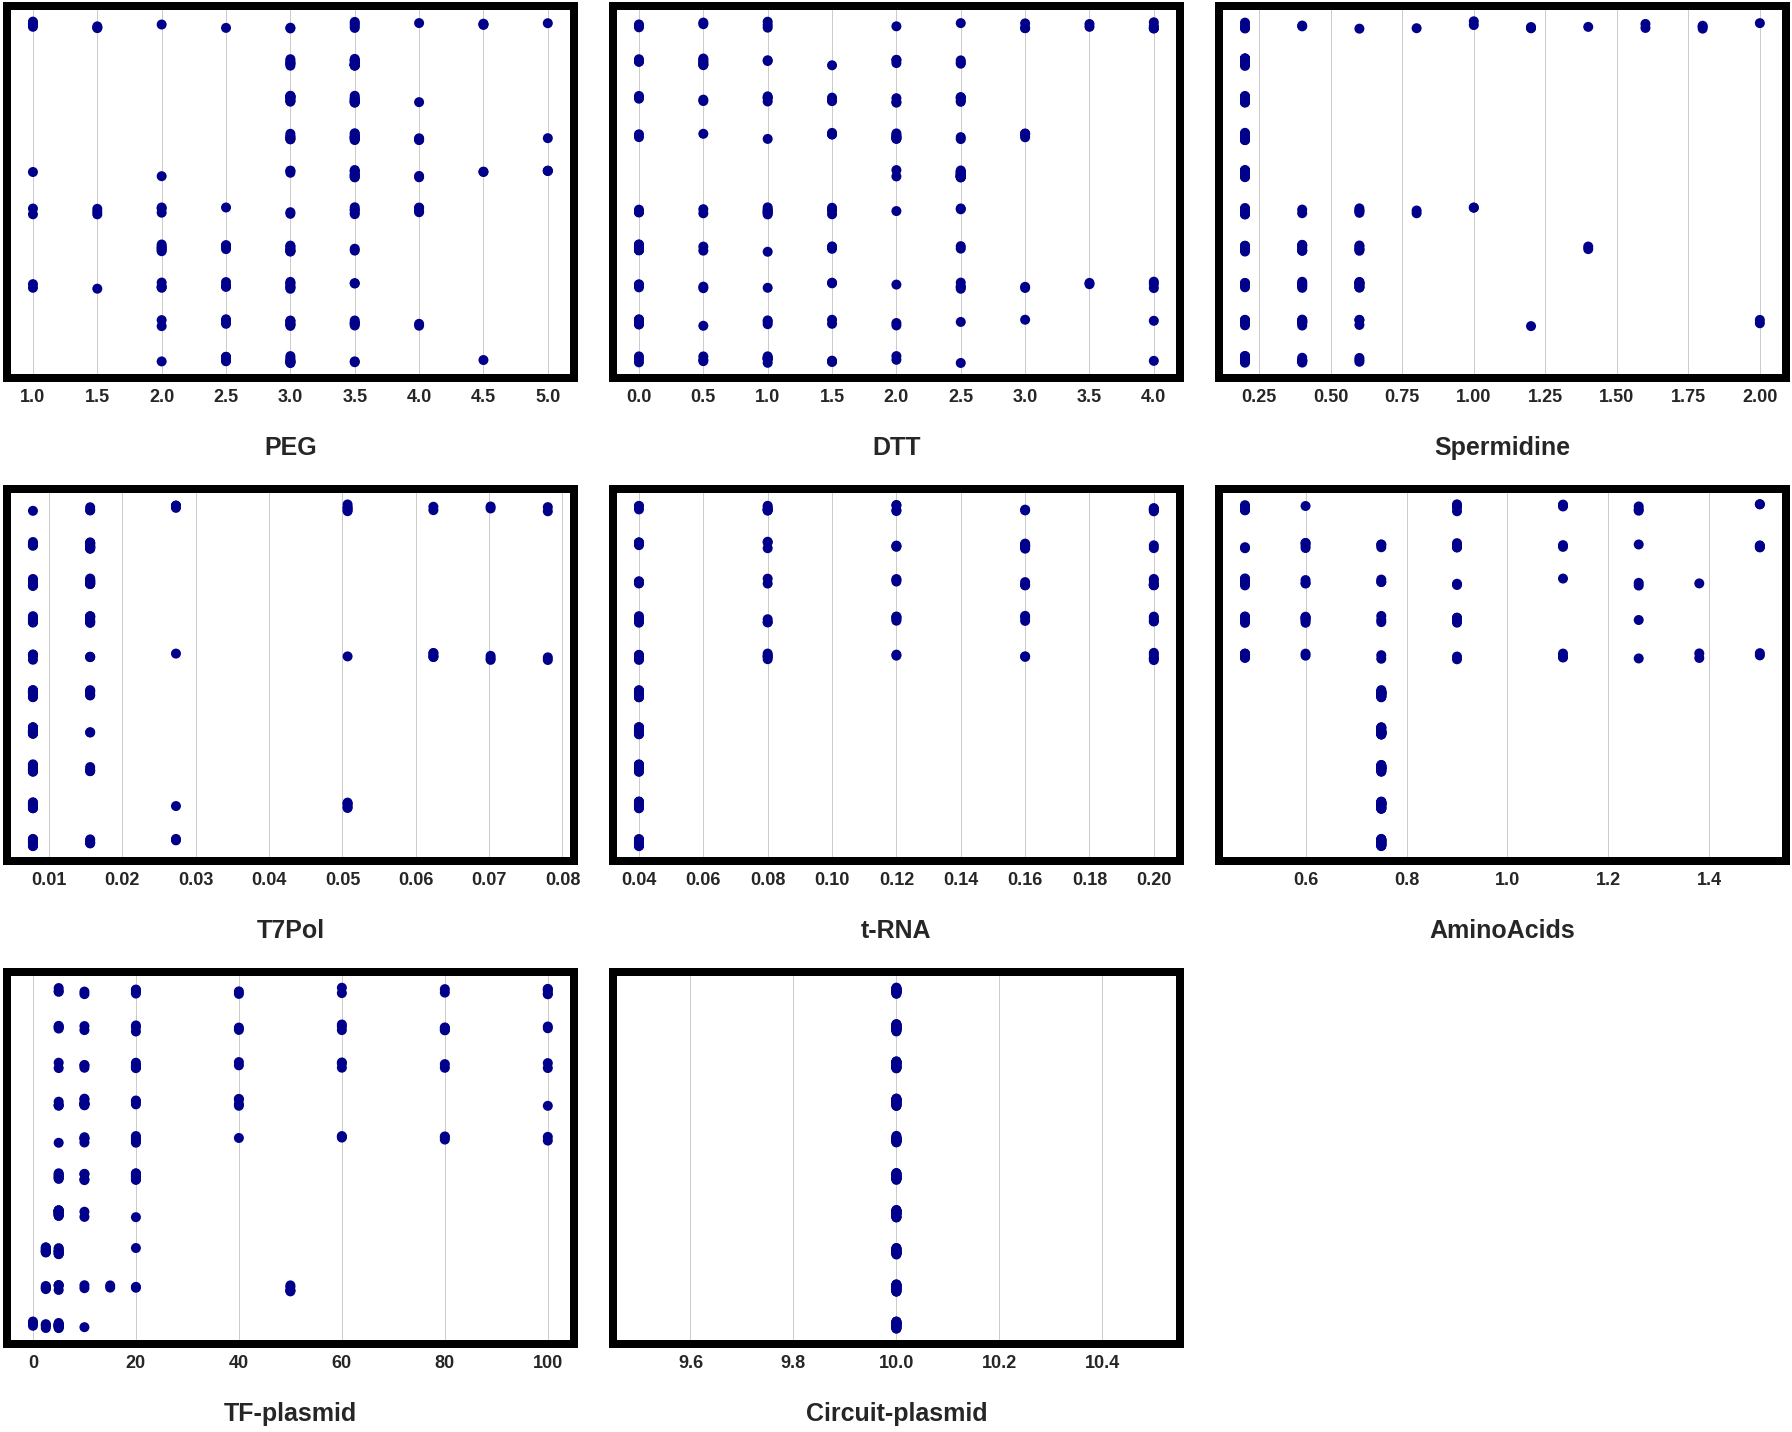

In [ ]:
data_all = pd.DataFrame(columns = list(concentrations_limits.keys())+['day'])
day = day_finder('Results')
desired_cols = []

for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

d = (1, 0)[os.path.isfile('Results_0.csv')]

while os.path.exists(f'Results_{d}.csv'):
    data = pd.read_csv(f'Results_{d}.csv')
    data = data[[*list(concentrations_limits.keys())]]
    data = data.iloc[:days_range[d-1],:]
    data['day'] = f'Day_{d}'
    data_all = pd.concat([data_all, data]).reset_index(drop=True)
    d += 1

import matplotlib as mpl


mpl.rcParams['axes.linewidth'] = 8.0 #set the value globally
mpl.rcParams['axes.edgecolor'] = 'black' #set the value globally
mpl.rcParams['xtick.major.pad'] = 10.0 #set the value globally


num = len(concentrations_limits)
dim = math.ceil(math.sqrt(num))

fig = plt.figure(figsize=(25,20))
for i in range(1, num+1):
    ax = plt.subplot(dim, dim, i)
    ax = sns.stripplot(x=list(concentrations_limits.keys())[i-1], y="day", color='darkblue', data=data_all, s=10)
    y_axis = ax.axes.get_yaxis()
    y_axis.set_label_text('foo')
    y_label = y_axis.get_label()
    y_label.set_visible(False)

    ax.yaxis.set_ticklabels([])
    plt.xticks(weight = 'bold', fontsize=18)

    plt.xlabel(desired_cols[i-1], labelpad=30 ,fontsize=25, weight='bold')


fig.tight_layout(h_pad=3, w_pad=3)

In [ ]:
fig.savefig(f'Day_{day-1}_Metabolite_Days.png', format='png', dpi=1200)
fig.savefig(f'Day_{day-1}_Metabolite_Days.svg', format='svg', dpi=1200)

# Transform Volumes.csv to Table2Speech Compatible Input

<p1><h2> When to use this part:</h2>
* you have at least one Volumes_n.csv file located in Day_n Folder 
<p1><h2> How to use this part:</h2>
* specify in "which_day" your Volumes file is located
* run all other cells!
* you can download Table2Speech_Volumes_n.csv file from Files

In [ ]:
which_day = 1 # i.e. Volumes_1.csv is in Day_1 Folder

In [ ]:
data = pd.read_csv(f'Day_{which_day}/Volumes_{which_day}.csv')

final_columns = []
columns_name = data.columns
for column in columns_name:
    if "_" in column:
        column_value = column.split('_')[0]
        column_to_add = data[column].unique()
        df_to_add = pd.DataFrame(columns = column_to_add,  data=np.zeros((len(data),len(column_to_add))))
        for i in range(len(data)):
            df_to_add[data[column].iloc[i,]][i] = data[column_value].iloc[i,]
        data = pd.concat([data, df_to_add], axis=1)
        final_columns.remove(column_value)
        final_columns += list(column_to_add)
    else:
        final_columns.append(column)

data = data[final_columns]
data

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,pSTAR,pTHS,pTAC,pDC,Lysate,EnergyBuffer,IPTG-Water,water
0,600.0,400.0,1000.0,1300.0,100.0,2500.0,400.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,2900.0
1,1800.0,0.0,400.0,1000.0,100.0,2500.0,50.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,3350.0
2,2000.0,100.0,500.0,1600.0,100.0,2500.0,400.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,2000.0
3,1400.0,300.0,100.0,1300.0,100.0,2500.0,800.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2700.0
4,1400.0,800.0,200.0,1000.0,100.0,2500.0,400.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,2800.0
5,1200.0,400.0,800.0,1800.0,100.0,2500.0,50.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2350.0
6,1200.0,400.0,1000.0,200.0,100.0,2500.0,100.0,0.0,0.0,0.0,200.0,6600.0,3500.0,500.0,3700.0
7,1800.0,700.0,200.0,2000.0,100.0,2500.0,600.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,1300.0
8,1400.0,200.0,100.0,2000.0,100.0,2500.0,400.0,0.0,0.0,0.0,200.0,6600.0,3500.0,500.0,2500.0
9,400.0,300.0,1000.0,1300.0,100.0,2500.0,400.0,0.0,0.0,0.0,200.0,6600.0,3500.0,500.0,3200.0


In [ ]:
data.to_csv(f'Table2Speech_Volumes_{which_day}.csv', index=False)

# Transform Volumes.csv to ECHO liquid Handler Compatible Input

<p1><h2> When to use this part:</h2>
* you have at least one Volumes_n.csv file located in Day_n Folder 
<p1><h2> How to use this part:</h2>
* specify in "which_day" your Volumes file is located
* run all other cells!
* you can download Echo_Input_n.csv file from Files

In [ ]:
which_day = 1 # i.e. Volumes_1.csv is in Day_1 Folder
plate_384_well = True
triplicate = False

In [ ]:
data = pd.read_csv(f'Day_{which_day}/Volumes_{which_day}.csv')

final_columns = []
columns_name = data.columns
for column in columns_name:
    if "_" in column:
        column_value = column.split('_')[0]
        column_to_add = data[column].unique()
        df_to_add = pd.DataFrame(columns = column_to_add,  data=np.zeros((len(data),len(column_to_add))))
        for i in range(len(data)):
            df_to_add[data[column].iloc[i,]][i] = data[column_value].iloc[i,]
        data = pd.concat([data, df_to_add], axis=1)
        final_columns.remove(column_value)
        final_columns += list(column_to_add)
    else:
        final_columns.append(column)

data = data[final_columns]
data

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,pDC,pTAC,pTHS,pSTAR,Lysate,EnergyBuffer,IPTG-Water,water
0,800.0,800.0,900.0,1300.0,100.0,2500.0,600.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,2200.0
1,1800.0,600.0,900.0,700.0,100.0,2500.0,50.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2550.0
2,800.0,400.0,1000.0,1000.0,100.0,2500.0,100.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,3300.0
3,1400.0,700.0,200.0,1000.0,100.0,2500.0,1000.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2300.0
4,600.0,300.0,800.0,400.0,100.0,2500.0,800.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,3700.0
5,800.0,700.0,700.0,1800.0,100.0,2500.0,400.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,2200.0
6,1400.0,0.0,300.0,1300.0,100.0,2500.0,800.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2800.0
7,1000.0,700.0,700.0,2000.0,100.0,2500.0,1000.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,1200.0
8,600.0,100.0,800.0,1600.0,100.0,2500.0,100.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,3400.0
9,1400.0,100.0,1000.0,1800.0,100.0,2500.0,1000.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,1300.0


In [ ]:
intermediate = put_volumes_to_384_wells(data, starting_well='A1', vertical=False, make_csv=False)
intermediate[1]

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,pDC,pTAC,pTHS,pSTAR,Lysate,EnergyBuffer,IPTG-Water,water,well_name
0,800.0,800.0,900.0,1300.0,100.0,2500.0,600.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,2200.0,A1
1,1800.0,600.0,900.0,700.0,100.0,2500.0,50.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2550.0,A2
2,800.0,400.0,1000.0,1000.0,100.0,2500.0,100.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,3300.0,A3
3,1400.0,700.0,200.0,1000.0,100.0,2500.0,1000.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2300.0,A4
4,600.0,300.0,800.0,400.0,100.0,2500.0,800.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,3700.0,A5
5,800.0,700.0,700.0,1800.0,100.0,2500.0,400.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,2200.0,A6
6,1400.0,0.0,300.0,1300.0,100.0,2500.0,800.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2800.0,A7
7,1000.0,700.0,700.0,2000.0,100.0,2500.0,1000.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,1200.0,A8
8,600.0,100.0,800.0,1600.0,100.0,2500.0,100.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,3400.0,A9
9,1400.0,100.0,1000.0,1800.0,100.0,2500.0,1000.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,1300.0,A10


In [ ]:
intermediate[0]['pTHS']

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
A,0.0,0.0,200.0,0.0,0.0,0.0,0.0,200.0,200.0,0.0,0.0,200.0,200.0,200.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
echo_input = source_to_destination(intermediate[1], desired_order=None, reset_index=True, check_zero=False)
echo_input[1]

,Source_Plate_Barcode,Source_Well,Destination_Plate_Barcode,Destination_Well,Transfer_Volume
0,Plate1,PEG well,destPlate1,A1,800.0
1,Plate1,PEG well,destPlate1,A2,1800.0
2,Plate1,PEG well,destPlate1,A3,800.0
3,Plate1,PEG well,destPlate1,A4,1400.0
4,Plate1,PEG well,destPlate1,A5,600.0
...,...,...,...,...,...
295,Plate1,water well,destPlate1,A16,3550.0
296,Plate1,water well,destPlate1,A17,2850.0
297,Plate1,water well,destPlate1,A18,4300.0
298,Plate1,water well,destPlate1,A19,1200.0


In [ ]:
echo_input[1].to_csv(f'Echo_Input_{which_day}.csv', index=False)

In [ ]:
echo_input[0]['PEG']

,Source_Plate_Barcode,Source_Well,Destination_Plate_Barcode,Destination_Well,Transfer_Volume
0,Plate1,PEG well,destPlate1,A1,800.0
1,Plate1,PEG well,destPlate1,A2,1800.0
2,Plate1,PEG well,destPlate1,A3,800.0
3,Plate1,PEG well,destPlate1,A4,1400.0
4,Plate1,PEG well,destPlate1,A5,600.0
5,Plate1,PEG well,destPlate1,A6,800.0
6,Plate1,PEG well,destPlate1,A7,1400.0
7,Plate1,PEG well,destPlate1,A8,1000.0
8,Plate1,PEG well,destPlate1,A9,600.0
9,Plate1,PEG well,destPlate1,A10,1400.0


# Find K Most Informative Combinations

<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file </p1>
<p1><h2> How to use this part:</h2>
* specify in "k" i.e. how many Combinations you want to get 
* run all other cells!
* you can download K_Most_Informative_Combinations.csv file from Files that contain index of most informative combinations for 5 iterations</p1>

In [ ]:
k = 20
number_try = 2000

In [ ]:
day = day_finder('Results') - 1
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

desired_cols = []
for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

aggregated_data_m = pd.DataFrame(columns=desired_cols)
aggregated_label_m = pd.DataFrame(columns=['yield'])

for num in range(start_day, day + 1):
    if start_day or num>0:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, days_range[num-1])
    else:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))

    aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)


aggregated_data_m

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_pTAC,Circuit-plasmid_pTHS,Circuit-plasmid_pDC,Circuit-plasmid_pSTAR
0,1.5,1.0,1.0,0.0273,0.12,1.50,40,10,0,0,1,0
1,1.0,4.0,1.6,0.0507,0.08,0.48,5,10,0,0,1,0
2,3.0,2.0,1.8,0.0507,0.08,0.48,5,10,0,1,0,0
3,2.5,4.0,0.2,0.0273,0.20,1.26,100,10,0,0,0,1
4,1.0,0.0,0.6,0.0273,0.08,1.11,60,10,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
195,2.0,2.5,0.2,0.0156,0.20,0.75,20,10,0,1,0,0
196,3.0,2.5,0.2,0.0702,0.16,0.60,80,10,0,1,0,0
197,3.5,2.0,0.2,0.0078,0.04,0.60,10,10,0,1,0,0
198,3.5,2.0,0.2,0.0078,0.16,0.48,60,10,0,1,0,0


In [ ]:
# Create the grid search parameter grid and scoring funcitons
param_grid = {
        "learning_rate": [0.01, 0.03, 0.1, 0.3],
        "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
        "subsample": [0.6, 0.8, 0.9, 1.0],
        "max_depth": [2, 3, 4, 6 , 8],
        "n_estimators": [10, 20,  40, 60, 80, 100, 300, 500],
        "reg_lambda": [1, 1.5, 2],
        "gamma": [0, 0.1, 0.4, 0.6],
        "min_child_weight": [1, 2, 4]}

# create the grid search object
grid = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_grid,
        cv=5,
        scoring= 'neg_mean_absolute_error',
        n_jobs=-1,
        n_iter=n_iter)
    
print('RandomSearchCV ...')
grid.fit(aggregated_data_m.values, aggregated_label_m.values)
results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
print('RandomSearchCV Done!')

RandomSearchCV ...
RandomSearchCV Done!


In [ ]:
indexs = []
num = 0
while num < number_try:
    numbers = set()
    while len(numbers) < k:
        numbers.add(random.randint(0, len(aggregated_data_m)-1))
    indexs.append(numbers)
    num += 1

In [ ]:
performance = []
best_param = results.params.iloc[0,]
all_set = set(range(len(aggregated_data_m)))
counter = 0
for index in indexs:
    counter += 1
    if counter%100 == 0:print(counter)
    index_test = all_set - index
    index_test = list(index_test)
    index = list(index)
    model = XGBRegressor(objective = 'reg:squarederror', **best_param)
    model.fit(aggregated_data_m.iloc[index].values, aggregated_label_m.iloc[index].values)
    performance.append(spearmanr(model.predict(aggregated_data_m.iloc[index_test].values), aggregated_label_m.iloc[index_test].values).correlation**2)

performance = np.array(performance)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


In [ ]:
number_to_select = 5
ind = np.argpartition(performance, -number_to_select)[-number_to_select:]
performance[ind]

array([0.6512688 , 0.65537355, 0.68188595, 0.65774891, 0.65573587])

In [ ]:
np.array(indexs)[ind]

array([{32, 36, 164, 134, 101, 8, 138, 139, 44, 109, 110, 13, 77, 18, 118, 119, 25, 27, 61, 159},
       {193, 68, 5, 38, 7, 105, 42, 143, 112, 113, 177, 17, 52, 147, 22, 151, 121, 155, 93, 158},
       {0, 1, 130, 33, 196, 198, 135, 8, 171, 44, 143, 48, 177, 112, 115, 61, 151, 156, 93, 62},
       {130, 99, 196, 5, 6, 197, 37, 9, 41, 138, 164, 173, 113, 114, 147, 19, 120, 90, 187, 188},
       {128, 193, 2, 162, 137, 138, 43, 173, 46, 112, 113, 179, 147, 85, 21, 152, 89, 59, 24, 159}],
      dtype=object)

In [ ]:
pd.DataFrame(np.array(indexs)[ind]).to_csv('K_Most_Informative_Combinations.csv', index=False)

# Find Feature Importances


<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file </p1>
<p1><h2> How to use this part:</h2>
* run all cells!
* you can download importance_df.csv  from Files</p1>

In [ ]:
n_iter = 200

In [6]:
day = day_finder('Results') - 1
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

desired_cols = []
for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

In [ ]:
importance_list = []
print('This may takes minutes!')

for day_i in range(1, day+1):
    aggregated_data_m = pd.DataFrame(columns=desired_cols)
    aggregated_label_m = pd.DataFrame(columns=['yield'])

    for num in range(start_day, day_i + 1):
        if start_day or num>0:
            data_m, label_m, _, _= result_preprocess(num, desired_cols, days_range[num-1])
        else:
            data_m, label_m, _, _= result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))

        aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
        aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)

    # Create the grid search parameter grid and scoring funcitons
    param_grid = {
        "learning_rate": [0.01, 0.03, 0.1, 0.3],
        "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
        "subsample": [0.6, 0.8, 0.9, 1.0],
        "max_depth": [2, 3, 4, 6 , 8],
        "n_estimators": [10, 20,  40, 60, 80, 100, 300, 500],
        "reg_lambda": [1, 1.5, 2],
        "gamma": [0, 0.1, 0.4, 0.6],
        "min_child_weight": [1, 2, 4]}

    # creat estimator
    model = XGBRegressor(objective = 'reg:squarederror')

    # create the grid search object
    grid = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_grid,
        cv=5,
        scoring= 'neg_mean_absolute_error',
        n_jobs=-1,
        n_iter=n_iter)
    
    print('RandomSearchCV ...', day_i)
    grid.fit(aggregated_data_m.values, aggregated_label_m.values)
    results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
    print('RandomSearchCV Done!')

    model = XGBRegressor(objective = 'reg:squarederror', **results.params.iloc[0,])
    model.fit(aggregated_data_m.values, aggregated_label_m.values)
    importance_list.append(model.feature_importances_)

In [ ]:
importance_df = pd.DataFrame(importance_list, columns=aggregated_data_m.columns)
importance_df

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_pTAC,Circuit-plasmid_pTHS,Circuit-plasmid_pDC,Circuit-plasmid_pSTAR
0,0.164611,0.006978,0.596009,0.151114,0.001064,0.003911,0.012810,0.0,0.011790,0.011826,0.029051,0.010837
1,0.008392,0.008170,0.219079,0.042871,0.131262,0.152478,0.326613,0.0,0.032282,0.014544,0.001962,0.062348
2,0.015973,0.014730,0.330768,0.070488,0.064746,0.050822,0.250360,0.0,0.034189,0.110949,0.006376,0.050598
3,0.023481,0.068850,0.161741,0.002777,0.055509,0.041766,0.256456,0.0,0.158289,0.149033,0.000442,0.081657
4,0.020968,0.027172,0.123663,0.106264,0.073056,0.059274,0.311707,0.0,0.074325,0.122916,0.023035,0.057621
5,0.090081,0.070063,0.134532,0.107644,0.083284,0.042501,0.294928,0.0,0.059599,0.086252,0.003652,0.027464
6,0.042291,0.032507,0.136297,0.064555,0.099923,0.025441,0.358116,0.0,0.087952,0.132899,0.005263,0.014756
7,0.036082,0.024758,0.055566,0.057797,0.106784,0.033161,0.446515,0.0,0.103038,0.096814,0.005369,0.034116
8,0.041365,0.025089,0.089266,0.076555,0.089245,0.042027,0.384968,0.0,0.076747,0.142317,0.008922,0.023499
9,0.069460,0.039310,0.076289,0.056598,0.099860,0.011600,0.460888,0.0,0.089973,0.083600,0.004986,0.007436


In [ ]:
importance_df.to_csv('importance_df.csv', index=False)

* find feature importance through 
sklearn.feature_selection.mutual_info_regression

In [16]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler

In [18]:
scaler_x = StandardScaler()
X = scaler_x.fit_transform(aggregated_data_m.values)
scaler_y = StandardScaler()
y = scaler_y.fit_transform(aggregated_label_m.values)

In [20]:
importance_df_sklearn = pd.DataFrame(mutual_info_regression(X, y)).T
importance_df_sklearn.columns = aggregated_data_m.columns
importance_df_sklearn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_pTAC,Circuit-plasmid_pTHS,Circuit-plasmid_pDC,Circuit-plasmid_pSTAR
0,0.139102,0.0,0.144418,0.121913,0.117898,0.0,0.192963,6.661338e-16,0.01174,0.16541,0.018181,0.036582


In [21]:
importance_df_sklearn.to_csv('importance_df_sklearn.csv', index=False)


# Find NonLinear Interactions

<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file </p1>
<p1><h2> How to use this part:</h2>
* run all cells!
* you can download Interactions.png from Files</p1>

In [131]:
day = day_finder('Results') - 1
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

desired_cols = []
for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

aggregated_data_m = pd.DataFrame(columns=desired_cols)
aggregated_label_m = pd.DataFrame(columns=['yield'])

for num in range(start_day, day + 1):
    if start_day or num>0:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, days_range[num-1])
    else:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))

    aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)


aggregated_data_m

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_pTAC,Circuit-plasmid_pTHS,Circuit-plasmid_pDC,Circuit-plasmid_pSTAR
0,1.5,1.0,1.0,0.0273,0.12,1.50,40,10,0,0,1,0
1,1.0,4.0,1.6,0.0507,0.08,0.48,5,10,0,0,1,0
2,3.0,2.0,1.8,0.0507,0.08,0.48,5,10,0,1,0,0
3,2.5,4.0,0.2,0.0273,0.20,1.26,100,10,0,0,0,1
4,1.0,0.0,0.6,0.0273,0.08,1.11,60,10,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
195,3.5,1.0,0.2,0.0156,0.04,0.75,5,10,0,1,0,0
196,2.5,1.0,0.4,0.0273,0.04,0.75,5,10,0,1,0,0
197,4.5,1.0,0.4,0.0078,0.04,0.75,5,10,0,1,0,0
198,3.0,4.0,0.2,0.0273,0.04,0.75,5,10,0,1,0,0


In [132]:
from sklearn.linear_model import LinearRegression
from itertools import combinations

model = LinearRegression()
model.fit(aggregated_data_m.values, aggregated_label_m.values)
baseline_score = pearsonr(pd.DataFrame(model.predict(aggregated_data_m.values))[0] ,aggregated_label_m['yield'])
baseline_score

(0.6395393719657679, 2.1404111389412567e-24)

In [133]:
interaction_scores = {}
for i in combinations(aggregated_data_m.columns, 2):
    X = pd.concat([aggregated_data_m, (aggregated_data_m[i[0]] * aggregated_data_m[i[1]])], axis=1)
    y = aggregated_label_m

    model = LinearRegression()
    model.fit(X.values, y.values)
    score = pearsonr(pd.DataFrame(model.predict(X.values))[0] ,y['yield'])

    interaction_scores[i] = score

In [134]:
interactions_df = pd.DataFrame(data=np.zeros([len(aggregated_data_m.columns), len(aggregated_data_m.columns)]), columns=aggregated_data_m.columns, index=aggregated_data_m.columns)

for columns, value in interaction_scores.items():
    diff = value[0] - baseline_score[0]
    interactions_df[columns[0]][columns[1]] = diff

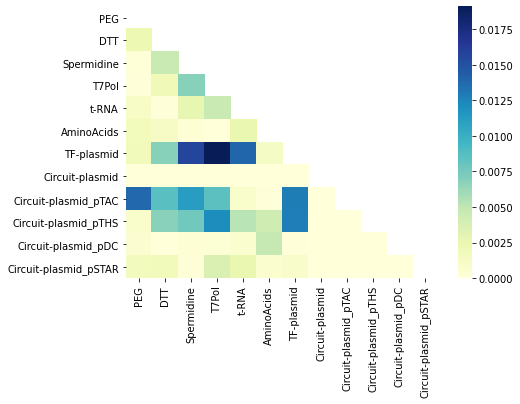

In [147]:
corr = np.corrcoef(np.random.randn(len(aggregated_data_m.columns), 200))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize = (7,5))
ax = sns.heatmap(interactions_df, mask=mask, cmap='YlGnBu')

In [136]:
fig.savefig('Interactions.png', format='png', dpi=1200)
fig.savefig('Interactions.svg', format='svg', dpi=1200)